In [ ]:
df = pd.read_csv('/content/Cars_Cleaned_Datasets - Cars Datasets 2025.csv', encoding='latin1')
print(df)

     Company Names          Car Names                             Engines  \
0          FERRARI      SF90 STRADALE                                  V8   
1      ROLLS ROYCE            PHANTOM                                 V12   
2             Ford                KA+                         1.2L Petrol   
3         MERCEDES            GT 63 S                                  V8   
4             AUDI         AUDI R8 Gt                                 V10   
...            ...                ...                                 ...   
1208        Toyota       Crown Signia                      2.5L Hybrid I4   
1209        Toyota  4Runner (6th Gen)  2.4L Turbo I4 (i-FORCE MAX Hybrid)   
1210        Toyota      Corolla Cross              2.0L Gas / 2.0L Hybrid   
1211        Toyota              C-HR+                  1.8L / 2.0L Hybrid   
1212        Toyota     RAV4 (6th Gen)        2.5L Hybrid / Plug-in Hybrid   

        CC/Battery Capacity      HorsePower Total Speed  \
0               

In [ ]:
df.describe()

,Company Names,Car Names,Engines,CC/Battery Capacity,HorsePower,Total Speed,Performance(0 - 100 )KM/H,Cars Prices,Fuel Types,Seats,Torque
count,1213,1213,1213,1213,1213,1213,1213,1213,1213,1213,1213
unique,36,1199,354,311,453,113,183,534,22,19,263
top,Nissan,Malibu Premier,I4,"2,000 cc",310 hp,250 km/h,6.5 sec,"$35,000",Petrol,5,400 Nm
freq,149,2,64,31,22,145,45,36,869,690,72


In [ ]:
df.count()

,0
Company Names,1213
Car Names,1213
Engines,1213
CC/Battery Capacity,1213
HorsePower,1213
Total Speed,1213
Performance(0 - 100 )KM/H,1213
Cars Prices,1213
Fuel Types,1213
Seats,1213


In [ ]:
import pandas as pd

PATH = "/content/Cars_Cleaned_Datasets - Cars Datasets 2025.csv"

# Load and normalize whitespace
df = pd.read_csv(PATH, encoding="utf-8")
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()

# Unique lists
engines = sorted(df["Engines"].unique())
fuels = sorted(df["Fuel Types"].unique())

print("Unique Engines:", len(engines))
for e in engines:
    print("-", e)

print("\nUnique Fuel Types:", len(fuels))
for f in fuels:
    print("-", f)

# Unique combinations (Engine, Fuel Type)
pairs = (
    df[["Engines", "Fuel Types"]]
    .drop_duplicates()
    .sort_values(["Engines", "Fuel Types"])
    .reset_index(drop=True)
)

print("\nUnique (Engine, Fuel Type) pairs:", len(pairs))
print(pairs.to_string(index=False))


Unique Engines: 354
- 0.36L Inline-2
- 0.66L Inline-3
- 0.7L 3-Cylinder
- 1.0L EcoBoost / 1.5L
- 1.0L EcoBoost / 1.5L / 2.0L
- 1.0L I3 Turbo
- 1.0L I3 Turbo / 1.5L I4 Turbo
- 1.0L Inline-2 (Wankel)
- 1.0L Turbo I3
- 1.0L Turbo I3 / 1.5L Turbo I4
- 1.0L Turbo I3 / 1.6L Diesel
- 1.0L Turbo Inline-3 / 2.0L
- 1.0L Turbo Inline-4
- 1.0L Turbocharged Inline-3
- 1.0L,INLINE-3
- 1.1L / 1.5L MIVEC
- 1.2L Diesel I3
- 1.2L Hybrid
- 1.2L I4 Gas
- 1.2L I4 Gas / 1.4L I4 Gas
- 1.2L I4 Turbo / 2.0L I4 Turbo
- 1.2L Inline-3
- 1.2L Inline-3 Hybrid
- 1.2L Inline-4
- 1.2L MIVEC
- 1.2L MPFI Petrol
- 1.2L Petrol
- 1.2L Revotron 3-cylinder Petrol
- 1.2L Revotron Bi-Fuel
- 1.2L Revotron Petrol
- 1.2L Revotron Petrol / 1.5L Diesel
- 1.2L Rotary
- 1.2L Turbo Inline-3 Gasoline
- 1.2L Turbo Petrol / 1.5L Diesel
- 1.2L Turbocharged Inline-4
- 1.2L Turbocharged Petrol
- 1.2L,4-CYLINDER,INLINE-4(I4)
- 1.3L Inline-2 (Wankel)
- 1.3L Inline-4
- 1.3L Quadrajet Diesel / 1.2L Revotron Petrol
- 1.3L Quadrajet Diesel / 1.4L

In [ ]:
# pipeline_v8.py
# End-to-end cleaning & variant splitting with:
# - Canonical fuel inference w/ your new overrides:
#   * "plug" anywhere (Engines/Fuel/Car Names)  -> PHEV (highest priority)
#   * "Gas" anywhere in row -> Petrol (unless CNG/LPG/Natural Gas explicitly present)
#   * Engines contains "Hybrid" -> Hybrid
#   * Engines contains "Bi-Fuel" -> CNG
#   * Engines contains "Petrol" -> Petrol
#   * If engine clearly ICE (I4/V6/Liters/EcoBoost/etc.) and no explicit fuel -> Petrol
# - Multi-engine splitting; per-variant assignment & interpolation
# - Enforce liters -> cc (e.g., 2.8L -> 2,800 cc)
# - Seats normalization (2+2 -> 4; ranges -> max)
# - Numeric conversion: HP, Torque, Total Speed, 0–100s, Cars Prices (USD midpoint for ranges)
# - Only extra column: variant_index

import re
import numpy as np
import pandas as pd

PATH_IN  = "/content/cars_clean_variants_pipeline_v7.csv"   # adjust if needed
PATH_OUT = "cars_clean_variants_pipeline_v8.csv"

# ---------- helpers ----------
def trim_all_obj(df):
    out = df.copy()
    for c in out.select_dtypes(include=["object"]).columns:
        out[c] = out[c].astype(str).str.replace(r"\s+", " ", regex=True).str.strip()
    return out

SEP = r"\s*/\s*"
def split_slash_list(s):
    if pd.isna(s) or s is None: return []
    return [p for p in re.split(SEP, str(s).strip()) if p != ""]

NUM_RE = re.compile(r"[-+]?\d[\d,]*\.?\d*")
def extract_numbers(s):
    if pd.isna(s) or s is None: return []
    out = []
    for m in NUM_RE.findall(str(s)):
        try: out.append(float(m.replace(",", "")))
        except: pass
    return out

def has_range(s):
    return False if (pd.isna(s) or s is None) else (len(extract_numbers(s)) >= 2)

def midpoint_from_text(s):
    nums = extract_numbers(s)
    if len(nums) >= 2: return (min(nums) + max(nums)) / 2.0
    if len(nums) == 1: return nums[0]
    return None

def parse_engine_disp_l(lbl):
    if pd.isna(lbl) or lbl is None: return np.nan
    m = re.search(r"(\d+(?:\.\d+)?)\s*[lL]", str(lbl))
    return float(m.group(1)) if m else np.nan

def liters_to_cc_str(liters):
    if pd.isna(liters): return None
    return f"{round(liters*1000):,d} cc"

def rank_engines(eng_labels, hp_list_or_none):
    n = len(eng_labels)
    if hp_list_or_none is not None and len(hp_list_or_none) == n and all(pd.notna(x) for x in hp_list_or_none):
        return list(np.argsort(hp_list_or_none))  # least->most
    disp = [parse_engine_disp_l(e) for e in eng_labels]
    if any(pd.notna(x) for x in disp):
        return list(np.argsort([x if pd.notna(x) else np.inf for x in disp]))
    return list(range(n))

def expand_to_n(values, n):
    if not values: return [np.nan]*n
    uniq = sorted(set(v for v in values if pd.notna(v)))
    if not uniq: return [np.nan]*n
    if len(uniq) == 1: return [uniq[0]]*n
    lo, hi = min(uniq), max(uniq)
    return np.linspace(lo, hi, n).tolist()

def assign_values_for_multi(values, n, engine_order, higher_is_better=True):
    vals = expand_to_n(values, n)
    vals_sorted = sorted(vals)
    assigned = [None]*n
    if higher_is_better:
        for rank, eng_idx in enumerate(engine_order): assigned[eng_idx] = vals_sorted[rank]
    else:
        for rank, eng_idx in enumerate(engine_order): assigned[eng_idx] = vals_sorted[n-1-rank]
    return assigned

def format_like_input(original_str, value, unit_hint=None):
    if pd.isna(value): return original_str
    s = str(original_str or "")
    if "$" in s or unit_hint == "usd": return "${:,.0f}".format(value)
    if "cc" in s.lower():  return "{:,.0f} cc".format(value)
    if "km/h" in s.lower() or "kmh" in s.lower(): return "{:,.0f} km/h".format(value)
    if "sec" in s.lower(): return "{:.1f} sec".format(value)
    if "hp" in s.lower() or "nm" in s.lower(): return "{:,.0f}".format(value)
    return "{:,.0f}".format(value)

# ---------- Fuel inference (v8, with your rules) ----------
ICE_CYL_PAT = re.compile(r"\b(i\d|v\d|inline|boxer|flat|wankel)\b", re.I)
LITERS_PAT  = re.compile(r"\b\d+(?:\.\d+)?\s*l\b", re.I)
CC_PAT      = re.compile(r"\b\d{3,5}\s*cc\b", re.I)
ICE_TRADE_NAMES = ("ecoboost","tfsi","tsi","gdi","mpi","t-gdi","tgi","turbo","multiair","skyactiv","dohc","sohc")

def _tok(s: str) -> str:
    if not s: return ""
    s = s.strip().lower()
    s = re.sub(r"[^a-z0-9+ ]", " ", s)
    s = re.sub(r"\s+", " ", s)
    return s

def _has_ice(engine_label: str, cc_text: str) -> bool:
    e = _tok(engine_label)
    c = _tok(cc_text)
    return (
        bool(LITERS_PAT.search(e)) or
        bool(ICE_CYL_PAT.search(e)) or
        bool(CC_PAT.search(c)) or
        any(t in e for t in ICE_TRADE_NAMES)
    )

def _contains_any(s: str, *words) -> bool:
    s = _tok(s)
    return any(w in s for w in words)

def _token_present(s: str, token: str) -> bool:
    return bool(re.search(rf"\b{re.escape(token)}\b", _tok(s)))

def infer_fuel_type_v8(engine_label: str, fuel_text: str, car_name: str, cc_text: str) -> str:
    eng = _tok(engine_label)
    fuel = _tok(fuel_text)
    name = _tok(car_name)
    row_all = f"{eng} {fuel} {name}"

    # PHEV priority
    if "plug" in row_all:
        return "PHEV"

    # Your explicit overrides
    if _token_present(row_all, "gas") or _token_present(row_all, "gasoline"):
        if not (_contains_any(row_all, "cng","compressed natural gas","lpg","autogas","natural gas")):
            return "Petrol"
    if "hybrid" in eng:
        return "Hybrid"
    if "bi fuel" in eng or "bifuel" in eng:
        return "CNG"
    if _contains_any(eng, "petrol","gasoline","benzin"):
        return "Petrol"

    # Alt fuels
    if _contains_any(row_all, "hydrogen","fuel cell","fcev"):
        return "Hydrogen"
    if _contains_any(row_all, "cng","compressed natural gas"):
        return "CNG"
    if _contains_any(row_all, "lpg","autogas"):
        return "LPG"
    if _contains_any(row_all, "flex","e85","ethanol"):
        return "Flex-Fuel"

    # Electric vs Hybrid via engine + ICE cross-check
    ice_present = _has_ice(engine_label, cc_text)
    is_electric_engine_only = ("electric" in eng) and ("+" not in eng) and not _contains_any(eng, "hybrid","hev","mhev","phev")
    if is_electric_engine_only and not ice_present:
        return "Electric"
    if ("+" in eng) or _contains_any(eng, "hybrid","hev","mhev") or (("electric" in eng) and ice_present):
        return "Hybrid"

    # Diesel if present anywhere in Engines/Fuel
    if _contains_any(eng+fuel, "diesel","tdi","dci","mjd","cdti","crdi"):
        return "Diesel"

    # If engine looks ICE but no explicit fuel -> Petrol
    if ice_present:
        return "Petrol"

    # Last-chance collapse from fuel_text alone
    if fuel:
        tokens = re.split(r"\s*[/,]| or | and \s*", fuel)
        mapped = set()
        for t in tokens:
            tt = _tok(t)
            if not tt: continue
            if "electric" in tt and not ice_present: mapped.add("Electric")
            if "electric" in tt and ice_present:     mapped.add("Hybrid")
            if "hybrid" in tt or "hev" in tt or "mhev" in tt: mapped.add("Hybrid")
            if "diesel" in tt:  mapped.add("Diesel")
            if re.search(r"\b(petrol|gasoline|benzin[e]?)\b", tt): mapped.add("Petrol")
            if "cng" in tt:     mapped.add("CNG")
            if "lpg" in tt:     mapped.add("LPG")
            if "hydrogen" in tt or "fuel cell" in tt or "fcev" in tt: mapped.add("Hydrogen")
            if "flex" in tt or "e85" in tt or "ethanol" in tt: mapped.add("Flex-Fuel")
        for pref in ("PHEV","Hybrid","Electric","CNG","LPG","Diesel","Petrol","Hydrogen","Flex-Fuel"):
            if pref in mapped:
                return pref

    return "Unknown"

# Seats normalization
def normalize_seats(val):
    if pd.isna(val): return np.nan
    s = str(val).strip().lower()
    if "+" in s:
        nums = [int(n) for n in re.findall(r"\d+", s)]
        return int(sum(nums)) if nums else np.nan
    if "-" in s:
        nums = [int(n) for n in re.findall(r"\d+", s)]
        return int(max(nums)) if nums else np.nan
    m = re.search(r"\d+", s)
    return int(m.group(0)) if m else np.nan

# Numeric converters
def to_float_first_number(val):
    if pd.isna(val): return np.nan
    nums = extract_numbers(val)
    return float(nums[0]) if nums else np.nan

def to_int_first_number(val):
    if pd.isna(val): return np.nan
    nums = extract_numbers(val)
    return int(round(nums[0])) if nums else np.nan

def hp_to_numeric(val):
    s = "" if pd.isna(val) else str(val).strip().lower()
    nums = extract_numbers(s)
    if not nums: return np.nan
    if re.search(r"\bup\s*to\b|\bupto\b", s): return max(nums)
    if re.search(r"[-–—]\s*\d", s) or "/" in s: return max(nums)
    return nums[0]

def torque_to_numeric(val):
    nums = [] if pd.isna(val) else extract_numbers(val)
    if not nums: return np.nan
    return max(nums) if len(nums) > 1 else nums[0]

def price_to_numeric(val, range_policy="midpoint"):
    if pd.isna(val): return np.nan
    nums = extract_numbers(val)
    if not nums: return np.nan
    if len(nums) == 1: return nums[0]
    if range_policy == "min":   return min(nums)
    if range_policy == "max":   return max(nums)
    if range_policy == "first": return nums[0]
    return (min(nums) + max(nums)) / 2.0

# ---------- pipeline ----------
df = pd.read_csv(PATH_IN, encoding="utf-8")
df = trim_all_obj(df)

req = ["Company Names","Car Names","Engines","CC/Battery Capacity","HorsePower","Total Speed",
       "Performance(0 - 100 )KM/H","Cars Prices","Fuel Types","Seats","Torque"]
missing = [c for c in req if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

rows_out = []
single_count = 0
multi_count  = 0

for _, row in df.iterrows():
    engines = split_slash_list(row["Engines"])

    # --- SINGLE ENGINE ---
    if len(engines) <= 1:
        out = row.to_dict()
        # midpoint ranges on these
        for col in ["HorsePower","Total Speed","Performance(0 - 100 )KM/H","Cars Prices","Torque"]:
            if has_range(out[col]):
                mid = midpoint_from_text(out[col])
                if mid is not None:
                    unit_hint = "usd" if col == "Cars Prices" else None
                    out[col] = format_like_input(out[col], mid, unit_hint=unit_hint)
        # enforce L->cc
        disp_l = parse_engine_disp_l(out["Engines"])
        cc_from_l = liters_to_cc_str(disp_l)
        if cc_from_l: out["CC/Battery Capacity"] = cc_from_l
        # fuel override (v8 rules)
        out["Fuel Types"] = infer_fuel_type_v8(out["Engines"], out["Fuel Types"], out["Car Names"], out["CC/Battery Capacity"])
        out["variant_index"] = 1
        rows_out.append(out)
        single_count += 1
        continue

    # --- MULTI ENGINE ---
    multi_count += 1
    n = len(engines)

    # per-engine HP (if provided)
    hp_parts = split_slash_list(row["HorsePower"])
    hp_vals_per_engine = []
    if len(hp_parts) == n:
        for part in hp_parts:
            nums = extract_numbers(part)
            hp_vals_per_engine.append(nums[0] if nums else np.nan)
    else:
        hp_vals_per_engine = None

    order = rank_engines(engines, hp_vals_per_engine)  # least->most

    # assign columns (interpolate if needed)
    cfg = [
        ("HorsePower", True,  None),
        ("Torque",     True,  None),
        ("Total Speed",True,  None),
        ("Performance(0 - 100 )KM/H", False, None),  # lower is better
        ("Cars Prices",True,  "usd"),
    ]
    def values_for(col):
        parts = split_slash_list(row[col])
        if len(parts) == n:
            return [extract_numbers(p)[0] if extract_numbers(p) else np.nan for p in parts]
        return extract_numbers(row[col])

    assigned = {}
    for col, hib, hint in cfg:
        if col == "HorsePower" and hp_vals_per_engine is not None:
            vals = hp_vals_per_engine
        else:
            vals = values_for(col)
        assigned[col] = assign_values_for_multi(vals, n, order, higher_is_better=(hib and col!="Performance(0 - 100 )KM/H"))

    # emit variants (enforce L->cc from engine label)
    for v in range(n):
        engine_label = engines[v]
        disp_l = parse_engine_disp_l(engine_label)
        cc_from_l = liters_to_cc_str(disp_l)
        if cc_from_l is None:
            cc_items = split_slash_list(row["CC/Battery Capacity"])
            if not cc_items and has_range(row["CC/Battery Capacity"]):
                nums = extract_numbers(row["CC/Battery Capacity"]); cc_vals = [min(nums), max(nums)]
            else:
                cc_vals = [extract_numbers(x)[0] if extract_numbers(x) else np.nan for x in cc_items]
            cc_assigned = assign_values_for_multi(cc_vals, n, order, higher_is_better=True)
            cc_val_fmt  = format_like_input(row["CC/Battery Capacity"], cc_assigned[v])
        else:
            cc_val_fmt = cc_from_l

        rows_out.append({
            "Company Names": row["Company Names"],
            "Car Names":     row["Car Names"],
            "Engines":       engine_label,
            "CC/Battery Capacity": cc_val_fmt,
            "HorsePower":    format_like_input(row["HorsePower"], assigned["HorsePower"][v]),
            "Total Speed":   format_like_input(row["Total Speed"], assigned["Total Speed"][v]),
            "Performance(0 - 100 )KM/H": format_like_input(row["Performance(0 - 100 )KM/H"], assigned["Performance(0 - 100 )KM/H"][v]),
            "Cars Prices":   format_like_input(row["Cars Prices"], assigned["Cars Prices"][v], unit_hint="usd"),
            "Fuel Types":    infer_fuel_type_v8(engine_label, row["Fuel Types"], row["Car Names"], row["CC/Battery Capacity"]),
            "Seats":         row["Seats"],
            "Torque":        format_like_input(row["Torque"], assigned["Torque"][v]),
            "variant_index": v+1
        })

final = pd.DataFrame(rows_out)

# Seats + numeric conversions
final["Seats"] = final["Seats"].apply(normalize_seats).astype("Int64")
final["Performance(0 - 100 )KM/H"] = final["Performance(0 - 100 )KM/H"].apply(to_float_first_number)
final["Total Speed"] = final["Total Speed"].apply(to_int_first_number).astype("Int64")
final["HorsePower"] = final["HorsePower"].apply(hp_to_numeric).astype(float)
final["Torque"]     = final["Torque"].apply(torque_to_numeric).astype(float)
final["Cars Prices"] = final["Cars Prices"].apply(price_to_numeric, range_policy="midpoint").round().astype("Int64")

final.to_csv(PATH_OUT, index=False)

print("Saved:", PATH_OUT)
print("Rows in:", len(df), "| Final variant rows:", len(final))

Saved: cars_clean_variants_pipeline_v8.csv
Rows in: 1275 | Final variant rows: 1275


In [ ]:
import pandas as pd

# Update this path to your latest processed file
PATH = "/content/cars_clean_variants_pipeline_v8.csv"

df = pd.read_csv(PATH, encoding="utf-8")

# Normalize fuel types to your 7-category canon
canon_map = {
    "petrol": "Petrol",
    "diesel": "Diesel",
    "phev": "PHEV",
    "cng": "CNG",
    "hybrid": "Hybrid",
    "electric": "Electric",
    "hydrogen": "Hydrogen",
}
df["Fuel Types"] = (
    df["Fuel Types"]
      .astype(str).str.strip().str.lower()
      .map(canon_map)
      .fillna("Unknown")
)

order = ["Petrol","Diesel","PHEV","CNG","Hybrid","Electric","Hydrogen","Unknown"]

# 1) Count by variant row (each variant is a “vehicle” row)
variant_counts = df["Fuel Types"].value_counts().reindex(order, fill_value=0)

# 2) Count unique model-by-fuel (unique Company+Car within each fuel)
model_fuel_counts = (
    df[["Fuel Types","Company Names","Car Names"]]
      .drop_duplicates()
      .groupby("Fuel Types").size()
      .reindex(order, fill_value=0)
)

print("Variant rows per fuel type:")
print(variant_counts.to_string())

print("\nUnique model (Company+Car) per fuel type:")
print(model_fuel_counts.to_string())

print("\nTotals:")
print({
    "variant_rows": int(variant_counts.sum()),
    "unique_model_fuels": int(model_fuel_counts.sum()),
})


Variant rows per fuel type:
Fuel Types
Petrol      927
Diesel      154
PHEV         14
CNG           2
Hybrid       79
Electric     94
Hydrogen      4
Unknown       1

Unique model (Company+Car) per fuel type:
Fuel Types
Petrol      887
Diesel      144
PHEV         14
CNG           2
Hybrid       78
Electric     94
Hydrogen      3
Unknown       1

Totals:
{'variant_rows': 1275, 'unique_model_fuels': 1223}


<Figure size 640x480 with 0 Axes>

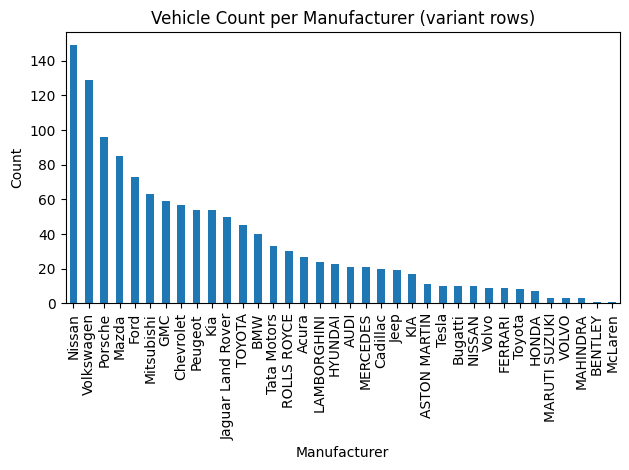

In [4]:
# Count per manufacturer/company and a chart (bar chart — better than box plot for counts)
import re
import pandas as pd
import matplotlib.pyplot as plt

PATH = "/content/carsdatasetcleaned.csv"

# Read
df = pd.read_csv(PATH, encoding="utf-8")

# Resolve company column name flexibly
def find_col(df, candidates):
    for c in candidates:
        for col in df.columns:
            if col.strip().lower() == c.strip().lower():
                return col
    return None

col_company = find_col(df, ["Company Names","Company","Brand","Make"])
if col_company is None:
    raise KeyError("Couldn't find a company/manufacturer column. Tried: Company Names, Company, Brand, Make.")

# Count rows per manufacturer (variant-level count)
counts = df.groupby(col_company).size().sort_values(ascending=False).to_frame(name="count")

# Plot a bar chart (counts are categorical; bar chart is appropriate.)
plt.figure()
counts.plot(kind="bar", legend=False)
plt.title("Vehicle Count per Manufacturer (variant rows)")
plt.xlabel("Manufacturer")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## **Creating Peer Groups**

In [6]:
import re
import numpy as np
import pandas as pd

PATH = "/content/carsdatasetcleaned.csv"

df = pd.read_csv(PATH, encoding="utf-8")

# --- column resolution ---
def find_col(df, candidates):
    for c in candidates:
        for col in df.columns:
            if col.strip().lower() == c.strip().lower():
                return col
    return None

col_fuel  = find_col(df, ["Fuel Types","Fuel","Fuel Type"])
col_seats = find_col(df, ["Seats"])
col_cc    = find_col(df, ["CC/Battery Capacity","CC","Displacement","Battery Capacity"])

# --- fuel canon (7) ---
canon_map = {
    "petrol":"Petrol","gasoline":"Petrol","gas":"Petrol",
    "diesel":"Diesel",
    "phev":"PHEV","plug-in hybrid":"PHEV","plug in hybrid":"PHEV",
    "cng":"CNG",
    "hybrid":"Hybrid","hev":"Hybrid","mhev":"Hybrid",
    "electric":"Electric","bev":"Electric",
    "hydrogen":"Hydrogen","fuel cell":"Hydrogen","fcev":"Hydrogen",
}
fuel_norm = (
    df[col_fuel].astype(str).str.strip().str.lower().map(canon_map).fillna(df[col_fuel])
)

# --- seats band ---
def seats_band(x):
    try:
        v = int(x)
    except Exception:
        m = re.findall(r"\d+", str(x))
        v = int(m[0]) if m else np.nan
    if pd.isna(v):  return np.nan
    if v == 2:      return "2 seater"
    if 3 <= v <= 5: return "5 seater"
    if 6 <= v <= 7: return "7 seater"
    if v >= 8:      return "8+ seater"
    return np.nan

# --- cc numeric ---
def cc_numeric(x):
    if pd.isna(x): return np.nan
    m = re.search(r"\d[\d,]*", str(x))
    return float(m.group(0).replace(",", "")) if m else np.nan

cc_num = df[col_cc].apply(cc_numeric)

# --- engine size band ---
def engine_size_band(fuel, cc):
    if fuel == "Electric":  return "EV"
    if fuel == "Hydrogen":  return "Hydrogen"
    if pd.isna(cc):         return "Unknown"
    if cc < 1500:           return "small"
    if cc <= 3000:          return "mid"
    return "large"

peers = pd.DataFrame({
    "Fuel": fuel_norm,
    "SeatsBand": df[col_seats].apply(seats_band),
    "EngineBand": [engine_size_band(f, c) for f, c in zip(fuel_norm, cc_num)],
})

valid_fuels = ["Petrol","Diesel","Hybrid","PHEV","CNG","Electric","Hydrogen"]
peers = peers[peers["Fuel"].isin(valid_fuels)]

peers["peer_id"] = peers["Fuel"] + " | " + peers["SeatsBand"].astype(str) + " | " + peers["EngineBand"].astype(str)

# counts per bucket
peer_counts = (
    peers.groupby(["Fuel","SeatsBand","EngineBand"])
         .size().reset_index(name="count")
         .sort_values(["Fuel","SeatsBand","EngineBand"])
)

print("Peer group buckets (Fuel × SeatsBand × EngineBand):")
print(peer_counts.to_string(index=False))

print("\nDistinct peer group labels:")
print(peers['peer_id'].drop_duplicates().sort_values().to_string(index=False))

print(f"\nTotal peer groups: {peers[['Fuel','SeatsBand','EngineBand']].drop_duplicates().shape[0]}")

Peer group buckets (Fuel × SeatsBand × EngineBand):
    Fuel SeatsBand EngineBand  count
     CNG  5 seater        mid      1
     CNG  5 seater      small      1
  Diesel  2 seater      large     12
  Diesel  2 seater        mid      5
  Diesel  5 seater      large     13
  Diesel  5 seater        mid     62
  Diesel  5 seater      small     17
  Diesel  7 seater      large     13
  Diesel  7 seater        mid     28
  Diesel 8+ seater      large      1
  Diesel 8+ seater        mid      3
Electric  2 seater         EV      5
Electric  5 seater         EV     83
Electric  7 seater         EV      6
  Hybrid  2 seater      large      4
  Hybrid  2 seater        mid      2
  Hybrid  5 seater      large     11
  Hybrid  5 seater        mid     41
  Hybrid  5 seater      small      8
  Hybrid  7 seater      large      3
  Hybrid  7 seater        mid      9
  Hybrid  7 seater      small      1
Hydrogen  5 seater   Hydrogen      2
    PHEV  2 seater      small      1
    PHEV  5 seater     

# **HuberRegressor**

In [10]:
"""
compute_vfm_exact_cols.py

Reads your cleaned cars dataset and computes a Value-for-Money (VFM) Index
with peer-wise standardization and pricing insights.

Columns expected (exact names):
  Company Names, Car Names, Engines, CC/Battery Capacity, HorsePower,
  Total Speed, Performance(0 - 100 )KM/H, Cars Prices, Fuel Types, Seats, Torque, variant_index

Peer groups:
  Fuel Types ∈ {Petrol, Diesel, Hybrid, PHEV, CNG, Electric, Hydrogen}
  SeatsBand ∈ {2, 4–5, 6–7, 8+}
  EngineBand:
    - ICE-like fuels: small <1500 cc, mid 1500–3000 cc, large >3000 cc
    - Electric: 'EV'
    - Hydrogen: 'Hydrogen'

Outputs:
  CSV with peer_id, robust z-scores, Performance composite, VFM_ratio, VFM_diff,
  and overpriced_pct vs peer (positive = overpriced).

CLI usage:
  python compute_vfm_exact_cols.py --in carsdatasetcleaned.csv --out cars_vfm_scores.csv

Notebook usage:
  Just run the cell; it will default to input='carsdatasetcleaned.csv' and out='cars_vfm_scores.csv'
"""

import argparse
import re
from typing import Optional, Tuple

import numpy as np
import pandas as pd

# Optional robust regression (falls back to OLS if unavailable)
try:
    from sklearn.linear_model import HuberRegressor
except Exception:
    HuberRegressor = None

# --------------------------
# Config (easy to tweak)
# --------------------------
FUEL_CANON = ["Petrol", "Diesel", "Hybrid", "PHEV", "CNG", "Electric", "Hydrogen"]
WEIGHTS = dict(hp=0.35, tq=0.20, vmax=0.20, acc=0.20, eff=0.05)  # eff=0 for EV/H2 rows
WINSOR_LO, WINSOR_HI = 0.01, 0.99

# --------------------------
# Column names (exact)
# --------------------------
COL_COMPANY   = "Company Names"
COL_MODEL     = "Car Names"
COL_ENGINES   = "Engines"
COL_CC        = "CC/Battery Capacity"
COL_HP        = "HorsePower"
COL_SPEED     = "Total Speed"
COL_ACCEL     = "Performance(0 - 100 )KM/H"
COL_PRICE     = "Cars Prices"
COL_FUEL      = "Fuel Types"
COL_SEATS     = "Seats"
COL_TORQUE    = "Torque"
COL_VARIANT   = "variant_index"

# --------------------------
# Helpers
# --------------------------
_num_re = re.compile(r"[-+]?\d[\d,]*\.?\d*")

def to_numeric_first(x) -> float:
    """Extract first numeric token from a string; return float or NaN."""
    if pd.isna(x): return np.nan
    m = _num_re.search(str(x))
    return float(m.group(0).replace(",", "")) if m else np.nan

def cc_numeric(x) -> float:
    """Extract numeric cc (or capacity) from CC/Battery Capacity as float."""
    if pd.isna(x): return np.nan
    m = re.search(r"\d[\d,]*", str(x))
    return float(m.group(0).replace(",", "")) if m else np.nan

def seats_band(val) -> Optional[str]:
    """Map seats to {2, 4–5, 6–7, 8+}."""
    if pd.isna(val): return np.nan
    try:
        v = int(val)
    except Exception:
        m = re.findall(r"\d+", str(val))
        v = int(m[0]) if m else np.nan
    if pd.isna(v): return np.nan
    if v == 2:      return "2"
    if 3 <= v <= 5: return "4–5"
    if 6 <= v <= 7: return "6–7"
    if v >= 8:      return "8+"
    return np.nan

def engine_size_band(fuel: str, cc: float) -> str:
    """Engine band per spec; Electric/Hydrogen get fixed labels."""
    if fuel == "Electric":  return "EV"
    if fuel == "Hydrogen":  return "Hydrogen"
    if pd.isna(cc):         return "Unknown"
    if cc < 1500:           return "small"
    if cc <= 3000:          return "mid"
    return "large"

def winsorize_series(s: pd.Series, lo=WINSOR_LO, hi=WINSOR_HI) -> pd.Series:
    """Clip to [lo-quantile, hi-quantile] for stability."""
    if s.dropna().empty: return s
    return s.clip(s.quantile(lo), s.quantile(hi))

def robust_z_within_group(s: pd.Series) -> pd.Series:
    """Robust z using median/IQR; fallback to std if IQR==0; then zeros (NaN-safe)."""
    med = s.median()
    q25, q75 = s.quantile(0.25), s.quantile(0.75)
    iqr = q75 - q25
    if pd.notna(iqr) and iqr != 0:
        return (s - med) / iqr
    std = s.std(ddof=0)
    if pd.notna(std) and std != 0:
        return (s - med) / std
    return pd.Series(0.0, index=s.index)

def fit_peer_price_model(perf: np.ndarray, log_price: np.ndarray) -> Tuple[float, float]:
    """
    Return slope, intercept for log_price ~ intercept + slope * perf.
    Robust to None/NaN and tiny groups; uses Huber if available else OLS.
    """
    y = np.asarray(log_price, dtype=float)
    x = np.asarray(perf, dtype=float).reshape(-1, 1)
    mask = np.isfinite(y) & np.isfinite(x).ravel()
    x, y = x[mask], y[mask]
    if x.size < 3:
        # Not enough points to fit a line; fall back to mean-only model
        return 0.0, float(np.nanmean(y) if y.size else 0.0)
    if (HuberRegressor is not None) and (y.size >= 8):
        try:
            m = HuberRegressor().fit(x, y)
            return float(m.coef_[0]), float(m.intercept_)
        except Exception:
            pass
    slope, intercept = np.polyfit(x.ravel(), y, 1)
    return float(slope), float(intercept)

def overpriced_pct_from_residual(resid_log_price: np.ndarray) -> np.ndarray:
    """Convert log-price residuals to % over/under-priced."""
    return (np.exp(resid_log_price) - 1.0) * 100.0

# --------------------------
# Core logic
# --------------------------
def compute_vfm(in_path: str, out_path: str):
    # 1) READ DATASET
    if in_path is None or str(in_path).strip() == "":
        raise ValueError("Input path is empty. Pass --in path/to/file.csv or set in_path programmatically.")

    df = pd.read_csv(in_path, encoding="utf-8")
    print(f"Loaded file: {in_path}  |  shape={df.shape}")
    print("Columns:", ", ".join(df.columns))

    # Validate required columns exist exactly
    required = [
        COL_COMPANY, COL_MODEL, COL_ENGINES, COL_CC, COL_HP, COL_SPEED,
        COL_ACCEL, COL_PRICE, COL_FUEL, COL_SEATS, COL_TORQUE, COL_VARIANT
    ]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing expected columns: {missing}")

    # 2) BASIC FIELDS (numeric coercion)
    fuel   = df[COL_FUEL].astype(str).str.strip()
    seatsB = df[COL_SEATS].apply(seats_band)
    cc     = df[COL_CC].apply(cc_numeric)
    hp     = df[COL_HP].apply(to_numeric_first)
    tq     = df[COL_TORQUE].apply(to_numeric_first)
    vmax   = df[COL_SPEED].apply(to_numeric_first)
    acc    = df[COL_ACCEL].apply(to_numeric_first)         # seconds
    price  = df[COL_PRICE].apply(to_numeric_first)

    # Canonicalize fuel to the 7 buckets (case-insensitive)
    canon = {k.lower(): k for k in FUEL_CANON}
    fuel_norm = fuel.str.lower().map(canon).fillna(fuel)

    # 3) ENGINE BAND + PEER GROUP (fill missing parts to avoid None issues)
    engBand = pd.Series([engine_size_band(f, c) for f, c in zip(fuel_norm, cc)], index=df.index)
    fuel_norm = fuel_norm.fillna("Unknown")
    seatsB    = seatsB.fillna("Unknown")
    engBand   = engBand.fillna("Unknown")
    peer_id   = fuel_norm.astype(str) + " | " + seatsB.astype(str) + " | " + engBand.astype(str)

    # 4) Assemble working table
    X = pd.DataFrame({
        "Company":    df[COL_COMPANY],
        "Model":      df[COL_MODEL],
        "Fuel":       fuel_norm,
        "SeatsBand":  seatsB,
        "EngineBand": engBand,
        "peer_id":    peer_id,
        "hp": hp, "tq": tq, "vmax": vmax, "acc_sec": acc, "cc": cc, "price": price
    })

    # For EV/Hydrogen, cc not required; others need cc
    is_ev_h2 = X["Fuel"].isin(["Electric", "Hydrogen"])
    need_ev  = ["hp","tq","vmax","acc_sec","price"]
    need_ice = need_ev + ["cc"]
    mask_ok = (is_ev_h2 & X[need_ev].notna().all(axis=1)) | (~is_ev_h2 & X[need_ice].notna().all(axis=1))
    X = X.loc[mask_ok].copy()

    # 5) Winsorize within peer (1%/99%) for stability
    def gw(col): return X.groupby("peer_id")[col].transform(lambda s: winsorize_series(s, WINSOR_LO, WINSOR_HI))
    for col in ["hp","tq","vmax","acc_sec","cc","price"]:
        X[col] = gw(col)

    # 6) Transform price to log (guard for non-positive)
    X["log_price"] = np.log(X["price"].clip(lower=1.0))

    # 7) Build "higher is better" features
    X["acc_pos"]   = -X["acc_sec"]            # lower seconds => higher is better
    X["eff_proxy"] = np.where(X["Fuel"].isin(["Electric","Hydrogen"]), 0.0, -X["cc"])  # smaller cc better (ICE)

    # 8) Robust z-scores within peer (median/IQR)
    def gz(col): return X.groupby("peer_id")[col].transform(robust_z_within_group)
    X["z_hp"]    = gz("hp")
    X["z_tq"]    = gz("tq")
    X["z_vmax"]  = gz("vmax")
    X["z_acc"]   = X.groupby("peer_id")["acc_pos"].transform(robust_z_within_group)
    X["z_eff"]   = X.groupby("peer_id")["eff_proxy"].transform(robust_z_within_group)
    X["z_price"] = gz("log_price")

    # 9) Performance composite (eff weight = 0 for EV/H2)
    eff_w = np.where(X["Fuel"].isin(["Electric", "Hydrogen"]), 0.0, WEIGHTS["eff"])
    X["perf"] = (
        WEIGHTS["hp"]   * X["z_hp"] +
        WEIGHTS["tq"]   * X["z_tq"] +
        WEIGHTS["vmax"] * X["z_vmax"] +
        WEIGHTS["acc"]  * X["z_acc"] +
        eff_w           * X["z_eff"]
    )

    # 10) VFM scores
    X["price_index"] = np.exp(X["z_price"])     # monotonic transform of price z
    X["VFM_ratio"]   = X["perf"] / X["price_index"]
    X["VFM_diff"]    = X["perf"] - 1.0 * X["z_price"]

    # 11) Peer-wise price model: log_price ~ perf (robust, NaN-safe, skip tiny groups)
    X["price_pred"]  = np.nan
    X["price_resid"] = np.nan
    for pid, g in X.groupby("peer_id"):
        perf = np.asarray(g["perf"], dtype=float)
        lp   = np.asarray(g["log_price"], dtype=float)
        mask = np.isfinite(perf) & np.isfinite(lp)
        if mask.sum() < 3:
            continue
        slope, intercept = fit_peer_price_model(perf[mask], lp[mask])
        pred  = intercept + slope * perf[mask]
        resid = lp[mask] - pred
        X.loc[g.index[mask], "price_pred"]  = pred
        X.loc[g.index[mask], "price_resid"] = resid

    X["overpriced_pct"] = overpriced_pct_from_residual(X["price_resid"].fillna(0.0))

    # 12) Save results
    out_cols = [
        "Company","Model","Fuel","SeatsBand","EngineBand","peer_id",
        "hp","tq","vmax","acc_sec","cc","price","log_price",
        "z_hp","z_tq","z_vmax","z_acc","z_eff","z_price",
        "perf","price_index","VFM_ratio","VFM_diff",
        "price_pred","price_resid","overpriced_pct"
    ]
    X[out_cols].to_csv(out_path, index=False)

    # Console summary
    print(f"\n Saved VFM results to: {out_path}")
    print(f"Rows scored: {len(X):,}")
    print("\nTop peer groups by volume:")
    print(X.groupby("peer_id").size().sort_values(ascending=False).head(10).to_string())

# --------------------------
# CLI & Notebook entry
# --------------------------
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--in",  dest="in_path",  default=None, help="Path to input CSV (cleaned dataset)")
    parser.add_argument("--out", dest="out_path", default="cars_vfm_scores.csv", help="Path to output CSV")
    # Use parse_known_args to avoid crashes in notebooks that inject args
    args, _ = parser.parse_known_args()

    if args.in_path is None:
        args.in_path = "/content/carsdatasetcleaned.csv"
        print("[info] --in not provided; defaulting to 'carsdatasetcleaned.csv'")

    compute_vfm(args.in_path, args.out_path)

[info] --in not provided; defaulting to 'carsdatasetcleaned.csv'
Loaded file: /content/carsdatasetcleaned.csv  |  shape=(1274, 12)
Columns: Company Names, Car Names, Engines, CC/Battery Capacity, HorsePower, Total Speed, Performance(0 - 100 )KM/H, Cars Prices, Fuel Types, Seats, Torque, variant_index

✅ Saved VFM results to: cars_vfm_scores.csv
Rows scored: 1,274

Top peer groups by volume:
peer_id
Petrol | 4–5 | mid      426
Petrol | 4–5 | large    142
Petrol | 4–5 | small    106
Electric | 4–5 | EV      83
Petrol | 2 | large       79
Petrol | 6–7 | large     71
Diesel | 4–5 | mid       62
Hybrid | 4–5 | mid       41
Petrol | 6–7 | mid       34
Petrol | 8+ | large      30
